In [1]:
DATA_TRAIN_PROCESSED = '../data/prepocessed/train.csv'

In [2]:
LOG_RESULTS = '../models/log/metrics_results.csv'

# Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define

## Model

In [5]:
from pmdarima.arima import auto_arima
import numpy as np

class SARIMAModel:
    def __init__(self, train_data):
        """
        Khởi tạo mô hình SARIMA.

        :param train_data: Dữ liệu huấn luyện (chuỗi thời gian).
        """
        self.train_data = train_data
        self.model = None
        self.order = None
        self.seasonal_order = None

    def fit(self, p=None, d=None, q=None, P=None, D=None, Q=None, m=1):
        """
        Huấn luyện mô hình SARIMA với các tham số chỉ định hoặc tìm tham số tối ưu.

        Args:
            p, d, q (int, optional): Tham số của phần ARIMA.
            P, D, Q (int, optional): Tham số của phần mùa vụ.
            m (int, optional): Chu kỳ mùa vụ (mặc định = 1, tức là không có mùa vụ).
        """
        self.model = auto_arima(
            self.train_data,
            p=p if p is not None else 0, max_p=p if p is not None else 5,
            d=d if d is not None else 0, max_d=d if d is not None else 2,
            q=q if q is not None else 0, max_q=q if q is not None else 5,
            P=P if P is not None else 0, max_P=P if P is not None else 2,
            D=D if D is not None else 0, max_D=D if D is not None else 1,
            Q=Q if Q is not None else 0, max_Q=Q if Q is not None else 2,
            m=m, 
            seasonal=(m > 1),  
            stepwise=True,
            trace=True
        )

        print(f"Best params: {self.model.summary()}")
        self.order = self.model.order
        self.seasonal_order = self.model.seasonal_order

    def predict(self, length):
        """
        Dự báo nhiều bước phía trước.

        :param length: Số bước cần dự báo.
        :return: DataFrame chứa giá trị dự báo và khoảng tin cậy.
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet. Please call fit() before predicting.")

        forecast, conf_int = self.model.predict(n_periods=length, return_conf_int=True)

        return np.array(forecast), np.array(conf_int)


## Task

In [6]:
def normalize_data(data, method="minmax"):
    """Chuẩn hóa dữ liệu theo phương pháp MinMax hoặc StandardScaler."""
    if method == "minmax":
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif method == "standard":
        scaler = StandardScaler()
    else:
        return data, None

    data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))
    return data_scaled, scaler

In [7]:
def inverse_scale(data_scaled, scaler):
    """
    Đảo ngược quá trình chuẩn hóa dữ liệu.

    Parameters:
        data_scaled (np.array): Dữ liệu đã được chuẩn hóa.
        scaler: Đối tượng scaler đã sử dụng để chuẩn hóa dữ liệu.

    Returns:
        np.array: Dữ liệu gốc sau khi đảo ngược chuẩn hóa.
    """
    if scaler is None:
        return data_scaled  
    data_original = scaler.inverse_transform(np.array(data_scaled).reshape(-1, 1))
    return data_original.flatten()

In [18]:
def plot_forecast(train_data, y_test, y_pred, model, index, conf_int=None):
    """
    Vẽ và lưu biểu đồ dự báo.

    Args:
        train_data (pd.Series): Dữ liệu huấn luyện.
        y_test (pd.Series): Dữ liệu thực tế.
        y_pred (np.array): Giá trị dự báo.
        model: Đối tượng model đã được huấn luyện (có thuộc tính `__class__.__name__`).
        index (int): Index của dòng metrics đã lưu.
        conf_int (np.array, optional): Khoảng tin cậy của dự báo.
    """
    plt.figure(figsize=(12, 6))

    train_index = train_data.index
    test_index = y_test.index

    model_name = model.__class__.__name__

    plt.plot(train_index, train_data, label="Original Data", color='gray', alpha=0.5)
    plt.plot(test_index, y_test, label="Actual", color='blue')
    plt.plot(test_index[:len(y_pred)], y_pred, label="Predicted", color='red', linestyle='dashed')

    # Vẽ khoảng tin cậy nếu có
    if conf_int is not None:
        conf_int = np.array(conf_int).reshape(-1, 2)
        lower_bound, upper_bound = conf_int[:, 0], conf_int[:, 1]
        plt.fill_between(test_index[:len(y_pred)], lower_bound, upper_bound, 
                         color='pink', alpha=0.3, label="Confidence Interval")

    # Cài đặt đồ thị
    plt.title(f"{model_name} Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(ncol=4)

    # Lưu hình ảnh với tên index_{Model}.png
    file_path = f"_{index}_{model_name}.png"
    plt.savefig(file_path, dpi=300)
    plt.close()

    print(f"Plot saved to {file_path}")


In [19]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from datetime import datetime

def compute_metrics(model, scaler, y_test, y_pred):
    """
    Tính toán các chỉ số đánh giá mô hình và trả về dưới dạng một dòng DataFrame.

    Args:
        model (object): Đối tượng mô hình (VD: ARIMA, RandomForest, LSTM,...)
        scaler (object): Bộ scaler đã sử dụng (VD: MinMaxScaler, StandardScaler,...)
        y_test (array-like): Giá trị thực tế
        y_pred (array-like): Giá trị dự đoán

    Returns:
        pd.DataFrame: Một dòng DataFrame chứa metrics đánh giá mô hình
    """

    model_name = model.__class__.__name__

    try:
        model_params = model.get_params()
    except AttributeError:
        try:
            model_params = model.order  # Cho ARIMA
        except AttributeError:
            model_params = "Unknown"

    scaler_name = scaler.__class__.__name__
    execution_date = datetime.today().strftime("%d-%m-%Y")
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    r2 = r2_score(y_test, y_pred)

    result = pd.DataFrame([{
        "Model": model_name,
        "Scaler": scaler_name,
        "Params": str(model_params),
        "MAPE": mape,
        "RMSE": rmse,
        "R2 Score": r2,
        "Execution Date": execution_date
    }])

    return result


In [17]:
import os

def save_metrics_to_csv(df, file_path):
    """
    Lưu DataFrame metrics vào file CSV. Nếu file chưa tồn tại thì tạo mới, 
    nếu đã tồn tại thì append dữ liệu vào.

    Args:
        df (pd.DataFrame): DataFrame chứa metrics của mô hình.
        file_path (str): Đường dẫn đến file CSV cần lưu.

    Returns:
        int: Index của dòng vừa được lưu.
    """
    file_exists = os.path.isfile(file_path)

    if file_exists:
        existing_df = pd.read_csv(file_path)
        last_index = existing_df.index[-1] + 1 if not existing_df.empty else 0
    else:
        last_index = 0

    df.index = range(last_index, last_index + len(df))

    # Lưu vào CSV
    df.to_csv(file_path, mode="a", index=False, header=not file_exists, encoding="utf-8")
    
    print(f"Metrics saved to {file_path}")
    
    return last_index 


# Run

In [11]:
data = pd.read_csv(DATA_TRAIN_PROCESSED)

* Configs

In [12]:
normalize ="standard"
model_type = 'SARIMA'

* Process

In [13]:
data_copy = data.copy()
data_copy["Date"] = pd.to_datetime(data_copy["Date"])
data_copy.set_index("Date", inplace=True)

* Split

In [14]:
split_idx = int(len(data_copy) * 0.8)
train_data = data_copy.iloc[:split_idx]
val_data = data_copy.iloc[split_idx:]
length_pred = len(val_data)

* Scale

In [15]:
train_scaled, scaler = normalize_data(train_data, method=normalize)
val_scaled = scaler.transform(val_data)

* Init model

In [16]:
model = SARIMAModel(train_scaled)

* fit model

In [424]:
model.fit(d=1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4256.037, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4848.500, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4770.510, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4624.583, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4846.507, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4255.748, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4275.070, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4288.928, Time=0.84 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4256.226, Time=1.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4254.226, Time=0.71 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4256.226, Time=0.79 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4258.118, Time=0.81 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4252.413, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4273.234, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]          

* forecast

In [425]:
predictions, conf_int = model.predict(length_pred)

* Inverse scale

In [426]:
y_pred = inverse_scale(predictions, scaler)
conf_int[:,0] = inverse_scale(conf_int[:,0], scaler)
conf_int[:,1] = inverse_scale(conf_int[:,1], scaler)

* Plot

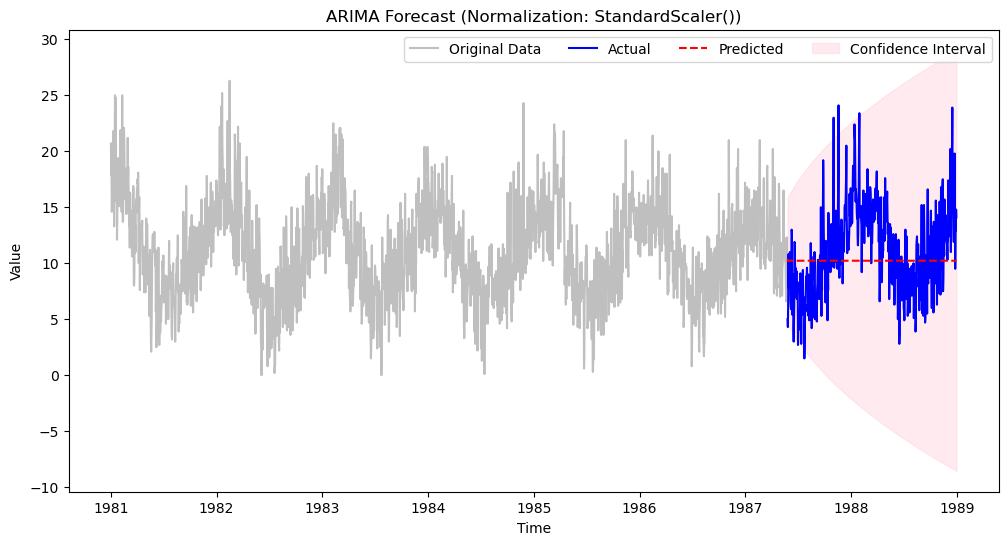

In [427]:
plot_forecast(train_data, val_data, y_pred, model_type, scaler, conf_int=conf_int)

In [429]:
df_metrics = compute_metrics(model, scaler, val_data.values, y_pred)
df_metrics

,Model,Scaler,Params,MAPE,RMSE,R2 Score,Execution Date
0,ARIMAModel,StandardScaler,"(0, 1, 3)",0.338293,3.982606,-0.055332,15-02-2025


In [430]:
save_metrics_to_csv(df_metrics, LOG_RESULTS)

Metrics saved to ../models/log/metrics_results.csv


In [431]:
pd.read_csv(LOG_RESULTS)

,Model,Scaler,Params,MAPE,RMSE,R2 Score,Execution Date
0,ARIMAModel,StandardScaler,"(3, 0, 1)",0.346660,3.890336,0.035631,15-02-2025
1,ARIMAModel,StandardScaler,"(0, 1, 3)",0.338293,3.982606,-0.055332,15-02-2025
